<div class="alert alert-block alert-info">

- [Import the needed libraries](#2nd-bullet)<br>
- [Import the dataset](#3rd-bullet)<br>
    
- [Filter methods](#6th-bullet)<br>
    - [Univariate variables](#7th-bullet)<br>
    - [Correlation Indices](#8th-bullet)<br>
    - [Chi-Square](#9th-bullet)<br>
- [Wrapper Methods](#10th-bullet)<br>
    - [RFE](#11th-bullet)<br>
        - [RFE Logistic Reg.](#12th-bullet)<br>
        - [RFE XGBoostClassifier.](#12th-bullet)<br>
- [Embedded Methods](#13th-bullet)<br>
    - [Lasso](#14th-bullet)<br>
- [Final Insights](#15th-bullet)<br>
    
</div>

# Chiel make the threshold between 0 and 0.2 dor correlation matrixes

<a class="anchor" id="2nd-bullet">

### Import the needed libraries
    
</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # setting seaborn default for plots

# data partition
from sklearn.model_selection import train_test_split


#filter methods
# spearman
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV
from xgboost import XGBClassifier

# embedded methods
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest  # mutual information is a embedded method for regression problems

# model assessment
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')


<a class="anchor" id="3rd-bullet">

### Import the dataset
    
</a>

In [2]:
import pandas as pd

# Import a smaller portion of the data
preproc_train = pd.read_csv('../data/traindf (2).csv').iloc[:1000]  
preproc_val = pd.read_csv('../data/valdf (2).csv').iloc[:1000] 
preproc_test = pd.read_csv('../data/testdf (2).csv').iloc[:1000] 

In [3]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder on the training data
label_encoder.fit(preproc_train['Claim Injury Type'])

# Copy Claim Injury Type as y variable
y = preproc_train['Claim Injury Type'].copy()
y_val = preproc_val['Claim Injury Type'].copy()

# Drop original column from X
X_preproc_train = preproc_train.drop('Claim Injury Type', axis=1)
X_preproc_val = preproc_val.drop('Claim Injury Type', axis=1)


# Transform the 'Claim Injury Type' column in both training and validation sets
preproc_train['Claim Injury Type'] = label_encoder.transform(preproc_train['Claim Injury Type'])
preproc_val['Claim Injury Type'] = label_encoder.transform(preproc_val['Claim Injury Type'])



In [4]:
y_preproc_train = preproc_train['Claim Injury Type']
X_preproc_train = preproc_train.drop(['Claim Injury Type'], axis=1)

y_preproc_val = preproc_val['Claim Injury Type']
X_preproc_val = preproc_val.drop(['Claim Injury Type'], axis=1)

In [5]:
X_preproc_train.shape, X_preproc_val.shape

((1000, 43), (1000, 43))

In [6]:

# #passar o claim identifier para o index

# y_preproc_train_copy = y_preproc_train.copy()

# y_preproc_train.set_index('Claim Identifier', inplace=True)

# y_preproc_val.set_index('Claim Identifier', inplace=True)

# X_preproc_train.set_index('Claim Identifier', inplace=True)

# preproc_test.set_index('Claim Identifier', inplace=True)

# X_preproc_val.set_index('Claim Identifier', inplace=True)


In [7]:
# drop Accident Month and Accident Day

X_preproc_train.drop(columns=['Accident Month', 'Accident Day'], inplace=True)
X_preproc_val.drop(columns=['Accident Month', 'Accident Day'], inplace=True)
preproc_test.drop(columns=['Accident Month', 'Accident Day'], inplace=True)

In [8]:
col_fill_median = ['Accident Month Cos', 'Accident Month Sin', 'Accident Day Cos', 'Accident Day Sin']

for col in col_fill_median:
    median_value = X_preproc_train[col].median()

    X_preproc_train[col].fillna(median_value, inplace=True)
    X_preproc_val[col].fillna(median_value, inplace=True)
    preproc_test[col].fillna(median_value, inplace=True)



In [9]:
#check for nan values
X_preproc_train.isna().sum().sort_values()

Assembly Date                       0
Above_65                            0
Accident Month Sin                  0
Accident Month Cos                  0
Accident Day Sin                    0
Accident Day Cos                    0
Received_C2                         0
Received_C3                         0
Hearing_held                        0
Attorney/Representative_Y           0
COVID-19 Indicator_Y                0
Alternative Dispute Resolution_Y    0
Gender_M                            0
wcio_pca1                           0
wcio_pca2                           0
region_cluster                      0
high_risk_nature                    0
high_risk_body                      0
Age_41_65                           0
high_risk_cause                     0
Age_21_40                           0
Days_to_Assembly                    0
Average Weekly Wage                 0
Birth Year                          0
C-2 Date                            0
C-3 Date                            0
Carrier Name

<div class="alert alert-block alert-success">

<a class="anchor" id="5th-bullet">    
    
## Feature Selection
    
</a>
    
</div>

<a class="anchor" id="6th-bullet">

## Filter methods
    
</a>

<a class="anchor" id="7th-bullet">

### Univariate variables
    
</a>

Check if any of the numerical variables is univariate (variance is equal to 0), then drop those variables if any of those exist.

from this we can tell that, there are no categorical features

In [10]:
X_preproc_train.var().sort_values()

Alternative Dispute Resolution_Y    0.001998
Under_20                            0.014790
Received_C2                         0.024399
Above_65                            0.025349
Days_to_Assembly                    0.025349
COVID-19 Indicator_Y                0.037517
high_risk_body                      0.040276
Agreement Reached                   0.045742
high_risk_cause                     0.091688
high_risk_nature                    0.113213
market_indicator                    0.135214
Hearing_held                        0.202679
Received_C3                         0.219243
Attorney/Representative_Y           0.224625
Age_21_40                           0.242498
Gender_M                            0.243018
Age_41_65                           0.249288
region_cluster                      0.722280
C-2 Date                            0.818819
Number of Dependents                0.950152
Accident Month Cos                  0.957601
Birth Year                          0.968264
County of 

No feature to be dropped from this one

In [11]:
X_preproc_train

,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,First Hearing Date,...,COVID-19 Indicator_Y,Alternative Dispute Resolution_Y,Gender_M,wcio_pca1,wcio_pca2,region_cluster,high_risk_nature,high_risk_body,high_risk_cause,market_indicator
0,-0.067360,1.213328,-0.495974,-0.064860,-1.263841,-0.575548,0.983139,1.274579,1.046863,-0.037533,...,0,0,0,0.610477,0.806579,0.162263,1,0,0,1
1,-0.908646,1.344678,0.955044,-0.783603,0.558209,-0.494377,-0.780636,0.384500,1.046863,-1.477658,...,0,0,0,-0.175047,0.713979,0.277415,0,0,1,1
2,1.012027,-0.755254,-0.133220,0.864313,0.558209,-0.209935,0.983139,1.040655,1.046863,-0.037533,...,0,0,1,-0.025755,0.530618,1.125027,0,0,0,0
3,0.056452,-0.755254,1.317798,0.041721,0.558209,-0.625062,-1.524399,1.040655,1.046863,-0.037533,...,0,0,1,-0.467459,-0.375868,-0.223555,0,0,0,0
4,-0.788009,0.889468,0.156984,-0.698884,-1.896900,-0.453747,-1.524399,0.574898,1.046863,-1.413414,...,0,0,1,0.104639,0.995235,0.774823,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.076884,-0.755254,-0.713627,-0.073059,0.558209,-0.474166,-0.780636,-0.072421,1.046863,-0.037533,...,0,0,1,-1.197156,0.165230,-0.361263,0,0,0,0
996,0.958057,1.261279,0.737391,0.790525,-0.142332,-0.362470,0.983139,-0.072421,1.046863,-0.037533,...,0,0,1,1.972633,-0.854960,0.423432,0,0,0,0
997,1.402510,-0.755254,0.809942,1.200454,0.558209,-0.219861,0.983139,-0.362467,-1.090599,-0.037533,...,0,0,0,-0.988781,-0.072032,0.077976,0,0,0,0
998,0.910437,0.997646,0.664840,0.768662,-0.193748,-0.568990,0.983139,1.040655,1.046863,-2.982025,...,0,0,1,0.543199,0.005466,-0.223555,0,0,0,0


<a class="anchor" id="8th-bullet">

### Correlation indices
    
</a>

In [103]:
X_preproc_train.head()



,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,First Hearing Date,...,COVID-19 Indicator_Y,Alternative Dispute Resolution_Y,Gender_M,wcio_pca1,wcio_pca2,region_cluster,high_risk_nature,high_risk_body,high_risk_cause,market_indicator
0,-0.067360,1.213328,-0.495974,-0.064860,-1.263841,-0.575548,0.983139,1.274579,1.046863,-0.037533,...,0,0,0,0.610477,0.806579,0.162263,1,0,0,1
1,-0.908646,1.344678,0.955044,-0.783603,0.558209,-0.494377,-0.780636,0.384500,1.046863,-1.477658,...,0,0,0,-0.175047,0.713979,0.277415,0,0,1,1
2,1.012027,-0.755254,-0.133220,0.864313,0.558209,-0.209935,0.983139,1.040655,1.046863,-0.037533,...,0,0,1,-0.025755,0.530618,1.125027,0,0,0,0
3,0.056452,-0.755254,1.317798,0.041721,0.558209,-0.625062,-1.524399,1.040655,1.046863,-0.037533,...,0,0,1,-0.467459,-0.375868,-0.223555,0,0,0,0
4,-0.788009,0.889468,0.156984,-0.698884,-1.896900,-0.453747,-1.524399,0.574898,1.046863,-1.413414,...,0,0,1,0.104639,0.995235,0.774823,0,0,0,0


### Dropping Binary and Cyclic Encoding Features

In [21]:
#drop binary columns
continuous_features = X_preproc_train.drop(columns=['COVID-19 Indicator_Y', 'Alternative Dispute Resolution_Y', 'Gender_M', 'high_risk_nature', 'Received_C2','Under_20', 'Age_21_40', 'Age_41_65', 'Age_41_65','Received_C3', 'Hearing_held', 'Attorney/Representative_Y', 'high_risk_body', 'high_risk_cause', 'market_indicator', 'Agreement Reached', 'Days_to_Assembly', "Accident Day Cos", 'Accident Day Sin', 'Accident Month Cos', 'Accident Month Sin'])

In [13]:
# round to 1 decimal places
continuous_features = continuous_features.round(1)
def cor_heatmap(cor):
    plt.figure(figsize=(24,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.2f')
    plt.show()

In [22]:

cor_spearman = continuous_features.corr(method ='spearman')
cor_spearman

,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,First Hearing Date,...,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Number of Dependents,Accident Year,Above_65,wcio_pca1,wcio_pca2,region_cluster
Assembly Date,1.000000,-0.015092,-0.067091,0.978883,0.146544,0.032760,-0.023342,-0.020153,-0.056986,0.391048,...,0.017532,-0.035329,-0.045756,-0.104453,-0.005240,-0.894355,-0.008773,-0.096216,-0.070003,-0.056679
Average Weekly Wage,-0.015092,1.000000,-0.099019,-0.020065,-0.424302,0.135660,-0.056966,0.080140,0.053344,-0.081482,...,0.056905,0.054345,0.099465,0.134372,0.001828,0.022647,-0.045618,0.153979,0.056987,0.058310
Birth Year,-0.067091,-0.099019,1.000000,-0.070783,0.049726,0.045638,0.008540,0.013887,-0.044808,-0.004373,...,-0.059145,-0.125313,-0.064570,-0.036630,-0.001990,0.074104,-0.274489,-0.113838,0.065197,-0.044267
C-2 Date,0.978883,-0.020065,-0.070783,1.000000,0.163201,0.032541,-0.008211,-0.036604,-0.078729,0.385126,...,0.017075,-0.038295,-0.034654,-0.103151,-0.009223,-0.884241,-0.000838,-0.088627,-0.068292,-0.064708
C-3 Date,0.146544,-0.424302,0.049726,0.163201,1.000000,-0.068458,0.057242,-0.142273,-0.152425,0.159561,...,0.014016,0.041623,-0.024703,-0.102340,-0.038799,-0.127309,-0.015753,-0.036075,-0.097956,-0.050672
Carrier Name,0.032760,0.135660,0.045638,0.032541,-0.068458,1.000000,-0.249044,0.060970,0.076145,0.059980,...,0.051416,-0.033349,0.051820,0.036054,-0.026155,-0.018761,-0.040113,0.039531,0.040368,0.066506
Carrier Type,-0.023342,-0.056966,0.008540,-0.008211,0.057242,-0.249044,1.000000,0.073371,0.065614,0.003976,...,-0.192710,-0.020585,-0.071009,-0.047983,-0.019238,0.009194,0.036932,-0.064623,-0.038413,0.042983
County of Injury,-0.020153,0.080140,0.013887,-0.036604,-0.142273,0.060970,0.073371,1.000000,0.390694,-0.008486,...,-0.024870,0.003446,-0.010034,0.070578,0.003328,0.021564,-0.029219,0.017832,0.044158,0.419240
District Name,-0.056986,0.053344,-0.044808,-0.078729,-0.152425,0.076145,0.065614,0.390694,1.000000,-0.061673,...,0.023526,0.008974,-0.040107,0.006583,0.012193,0.046252,0.028125,-0.026331,-0.003571,0.229137
First Hearing Date,0.391048,-0.081482,-0.004373,0.385126,0.159561,0.059980,0.003976,-0.008486,-0.061673,1.000000,...,0.017036,0.025008,-0.034417,-0.068561,0.024449,-0.357772,-0.026976,-0.040414,-0.084810,-0.004072


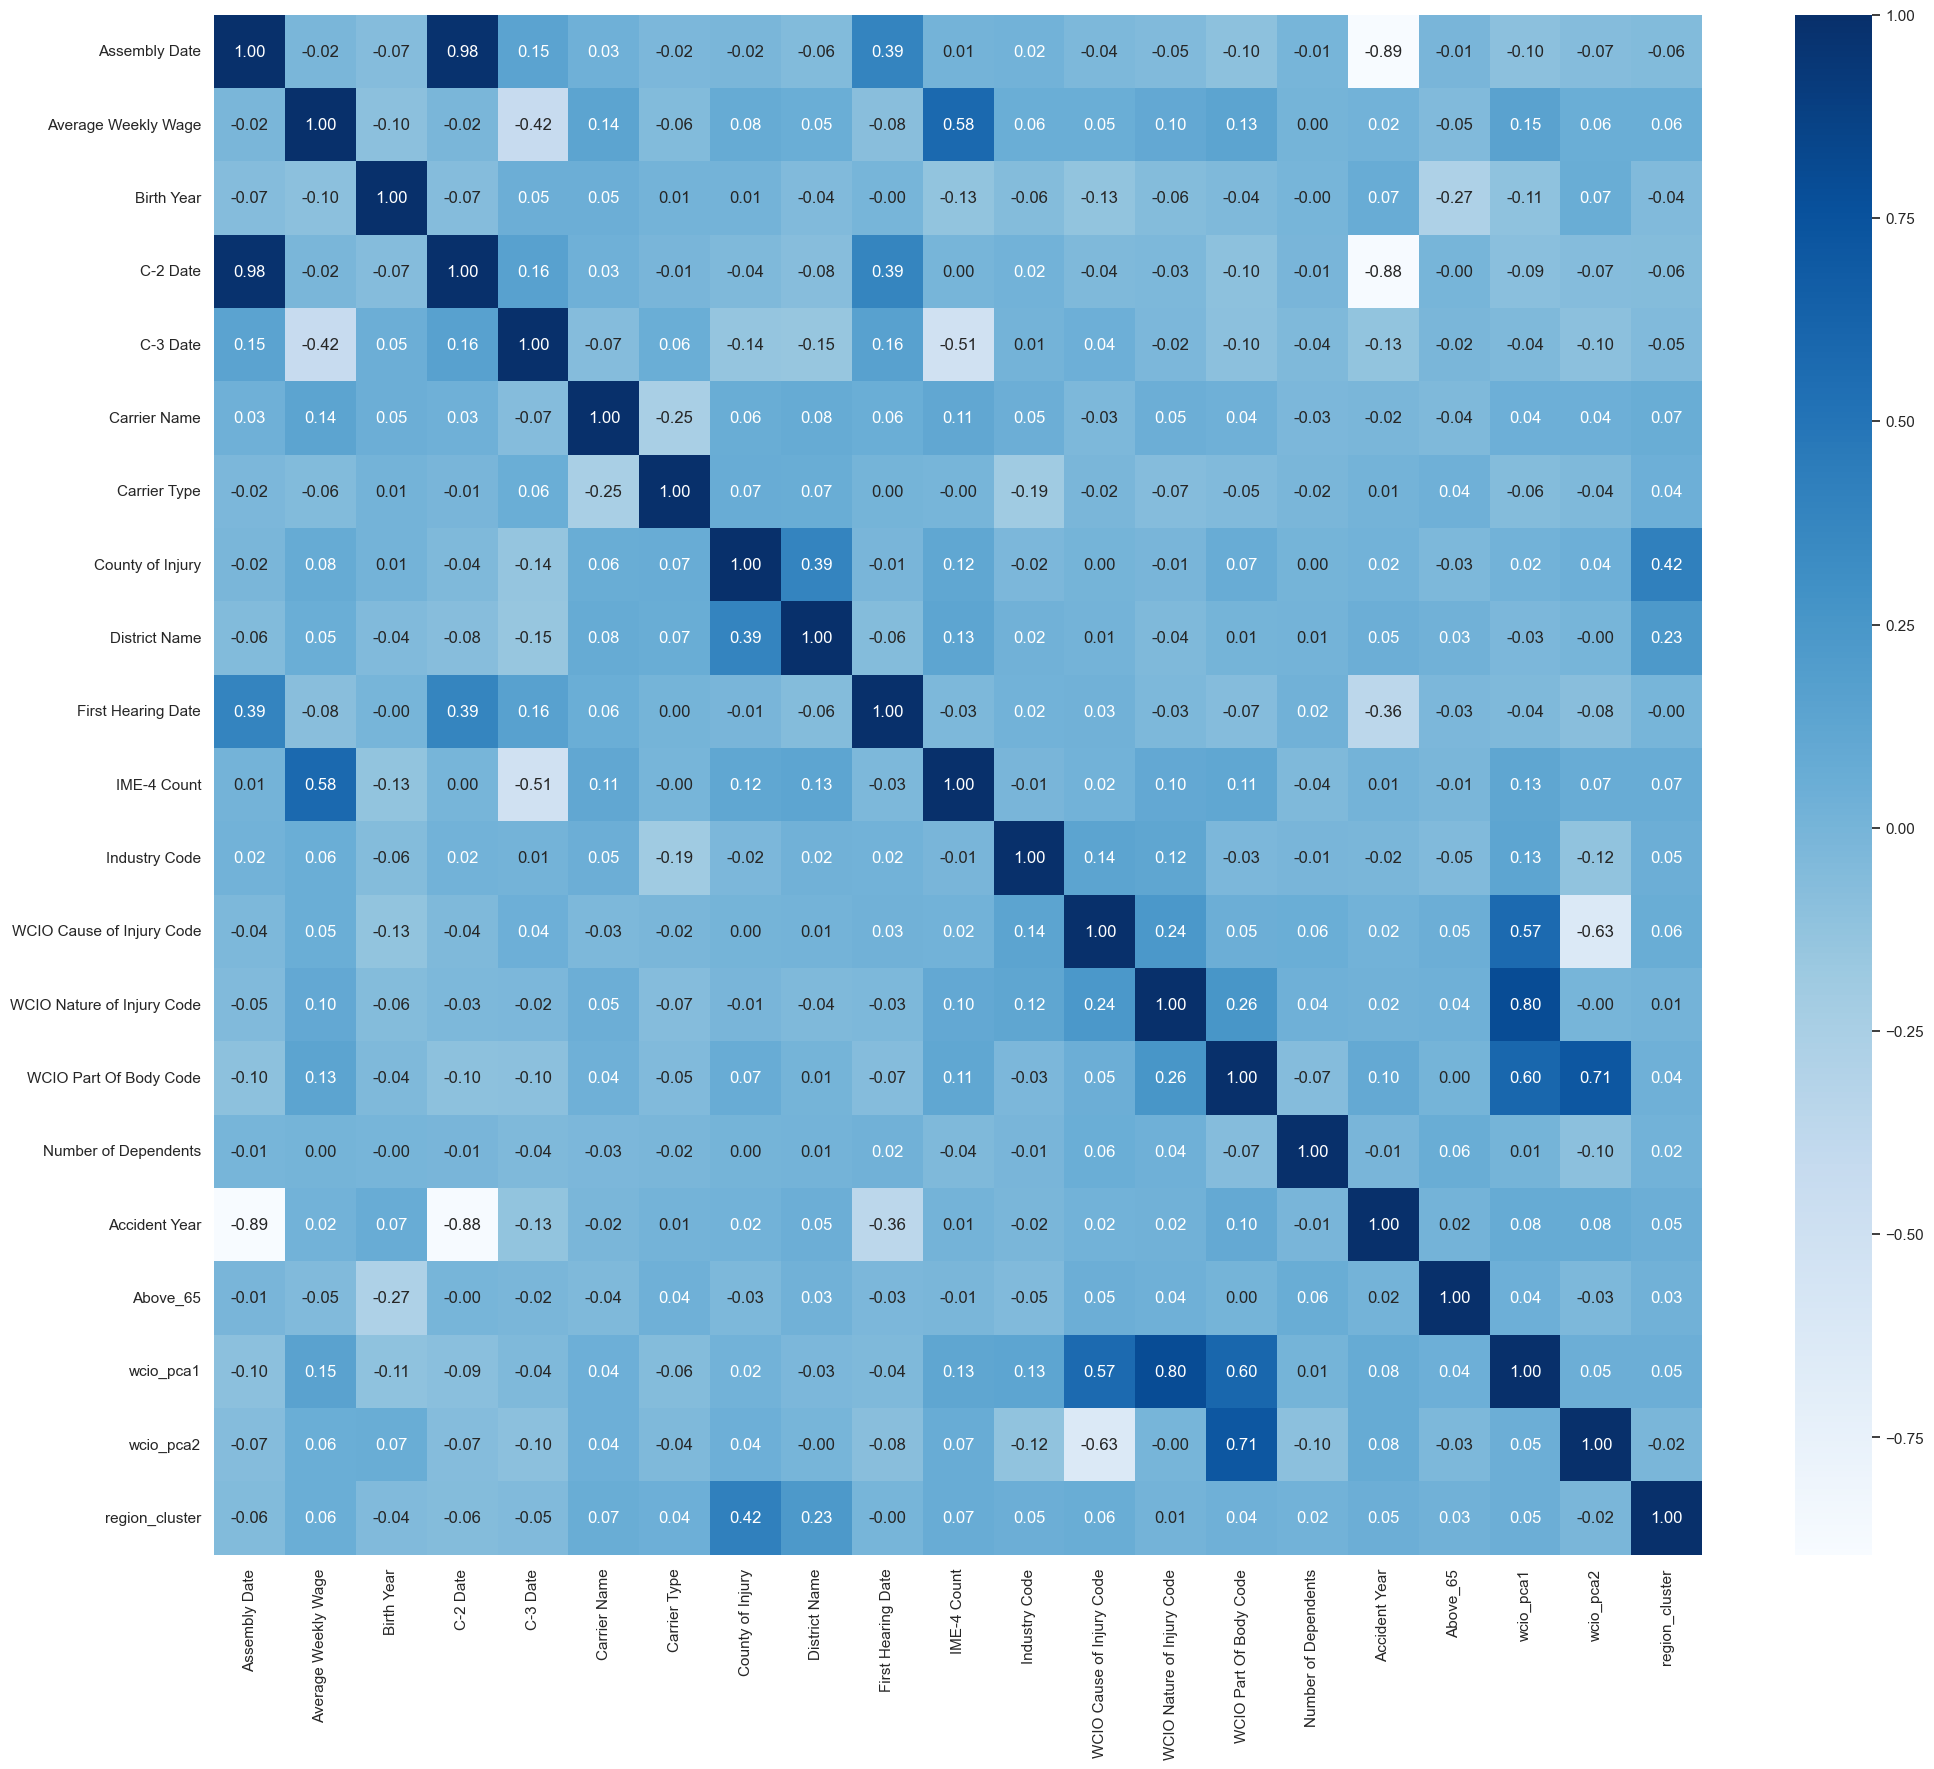

In [77]:
cor_heatmap(cor_spearman)

# cor_spearman = continuous_features.corr(method='spearman')

# # Filter the correlation matrix
# filtered_cor = cor_spearman[
#             (cor_spearman > 0.8)
# ]

# # Remove diagonal part
# filtered_cor = filtered_cor.mask(np.equal(*np.indices(filtered_cor.shape)))

# # Stack the filtered correlation matrix and reset the index
# stacked_cor = filtered_cor.stack().reset_index()

# # Filter out NaN values and correlations equal to 1
# filtered_stacked_cor = stacked_cor[
#     stacked_cor[0].notnull() & (stacked_cor[0] != 1)
# ]

# # Print the features and their correlation values with messages
# for index, row in filtered_stacked_cor.iterrows():
#     feature1 = row['level_0']
#     feature2 = row['level_1']
#     correlation = row[0]

#     if correlation > 0.79:
#         print(f"Correlation between {feature1} and {feature2} is above 0.8: {correlation:.2f}")

#     elif correlation < 0.2 and correlation > 0:
#         print(f"Correlation between {feature1} and {feature2} is below 0.2: {correlation:.2f}")



We will assume that the Thresholds for feature relevance is 0.2 and redundance for 0,8


### Redundancy
drop 'wcio_pca1' or 'WCIO Nature of Injury Code'

drop 'c2 date' or 'Assembly date'


### Relevance

Drop Number of depndents

Drop Industry code

Drop Birth Year






<a class="anchor" id="15th-bullet">

### Mutual Information Classification
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.SelectKBest.html
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.mutual_info_regression.html
</a>

In [37]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(12,8))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

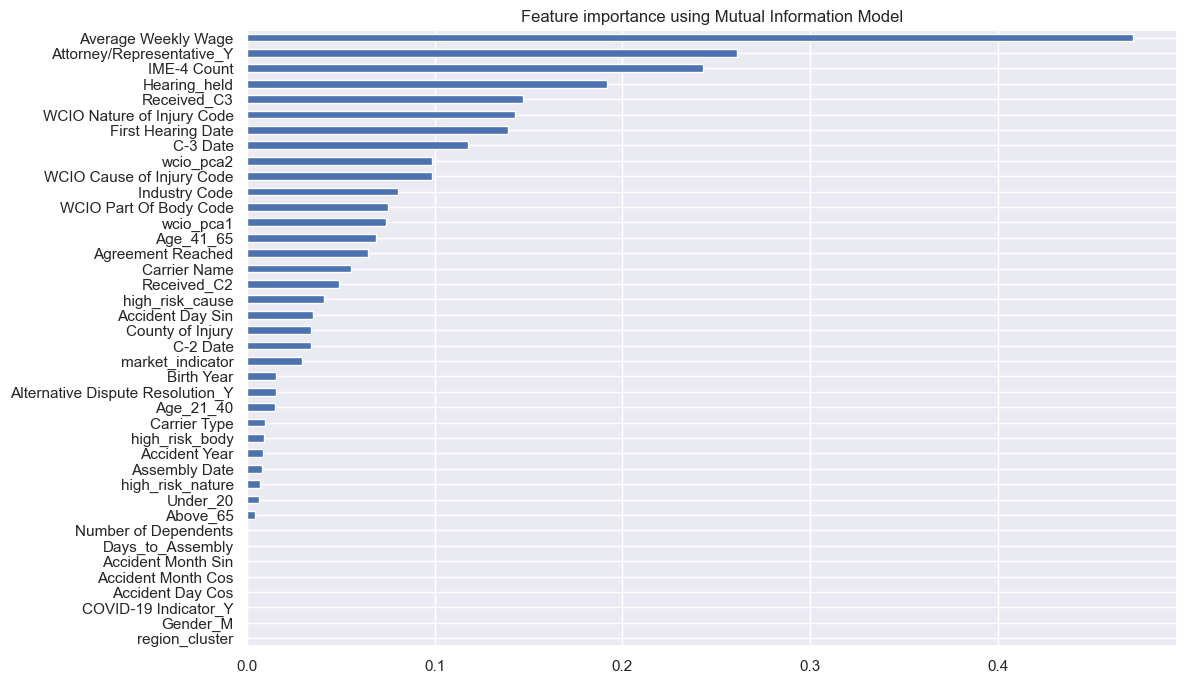

18Features to be eliminated:
Features to be eliminated: 
Index(['Assembly Date', 'Birth Year', 'Carrier Type', 'Number of Dependents',
       'Accident Year', 'Days_to_Assembly', 'Under_20', 'Age_21_40',
       'Above_65', 'Accident Month Sin', 'Accident Month Cos',
       'Accident Day Cos', 'COVID-19 Indicator_Y',
       'Alternative Dispute Resolution_Y', 'Gender_M', 'region_cluster',
       'high_risk_nature', 'high_risk_body'],
      dtype='object')
Feature                        Score     
----------------------------------------
Assembly Date                  0.0079    
Average Weekly Wage            0.4716    
Birth Year                     0.0158    
C-2 Date                       0.0340    
C-3 Date                       0.1179    
Carrier Name                   0.0552    
Carrier Type                   0.0096    
County of Injury               0.0340    
First Hearing Date             0.1390    
IME-4 Count                    0.2431    
Industry Code                  0.0807 

In [59]:
#  Mutual Information Regression for feature selection in regression problems
mic = SelectKBest(score_func= mutual_info_classif, k= 'all')

# fit the model to the training data
mic.fit(X_preproc_train, y_preproc_train)

# get the scores of the features
mic_scores = pd.Series(mic.scores_, index = X_preproc_train.columns)

# plot the scores
plot_importance(mic_scores,'Mutual Information')
mic_scores.sort_values()

#print the features that were eliminated

eliminated_features = mic_scores[mic_scores <= 0.0243].index
print(f"{len(eliminated_features)}Features to be eliminated:")
print(f"Features to be eliminated: \n{eliminated_features}")
# Print formatted table
print(f"{'Feature':<30} {'Score':<10}")
print("-" * 40)
for feature, score in mic_scores.items():
    print(f"{feature:<30} {score:<10.4f}")
    


   
### Dropping the ones with importance lower than their supposed contribution : 
Assembly Date', 'Birth Year', 'C-2 Date', 'Carrier Type',
       'County of Injury', 'District Name', 'Number of Dependents',
       'Accident Year', 'Under_20', 'Age_21_40', 'Age_41_65', 'Above_65',
       'Accident Month Sin', 'Accident Month Cos', 'Accident Day Cos',
       'Received_C2', 'COVID-19 Indicator_Y',
       'Alternative Dispute Resolution_Y', 'Gender_M', 'region_cluster',
       'high_risk_body', 'high_risk_cause', 'market_indicator'

# VIF Variance Information Factor


Strict threshold (5):
Features to drop: 8
Features: ['Age_41_65', 'Age_21_40', 'market_indicator', 'Assembly Date', 'high_risk_nature', 'C-2 Date', 'Received_C3', 'C-3 Date']

Moderate threshold (10):
Features to drop: 3
Features: ['Age_41_65', 'Age_21_40', 'market_indicator']

Lenient threshold (20):
Features to drop: 1
Features: ['Age_41_65']


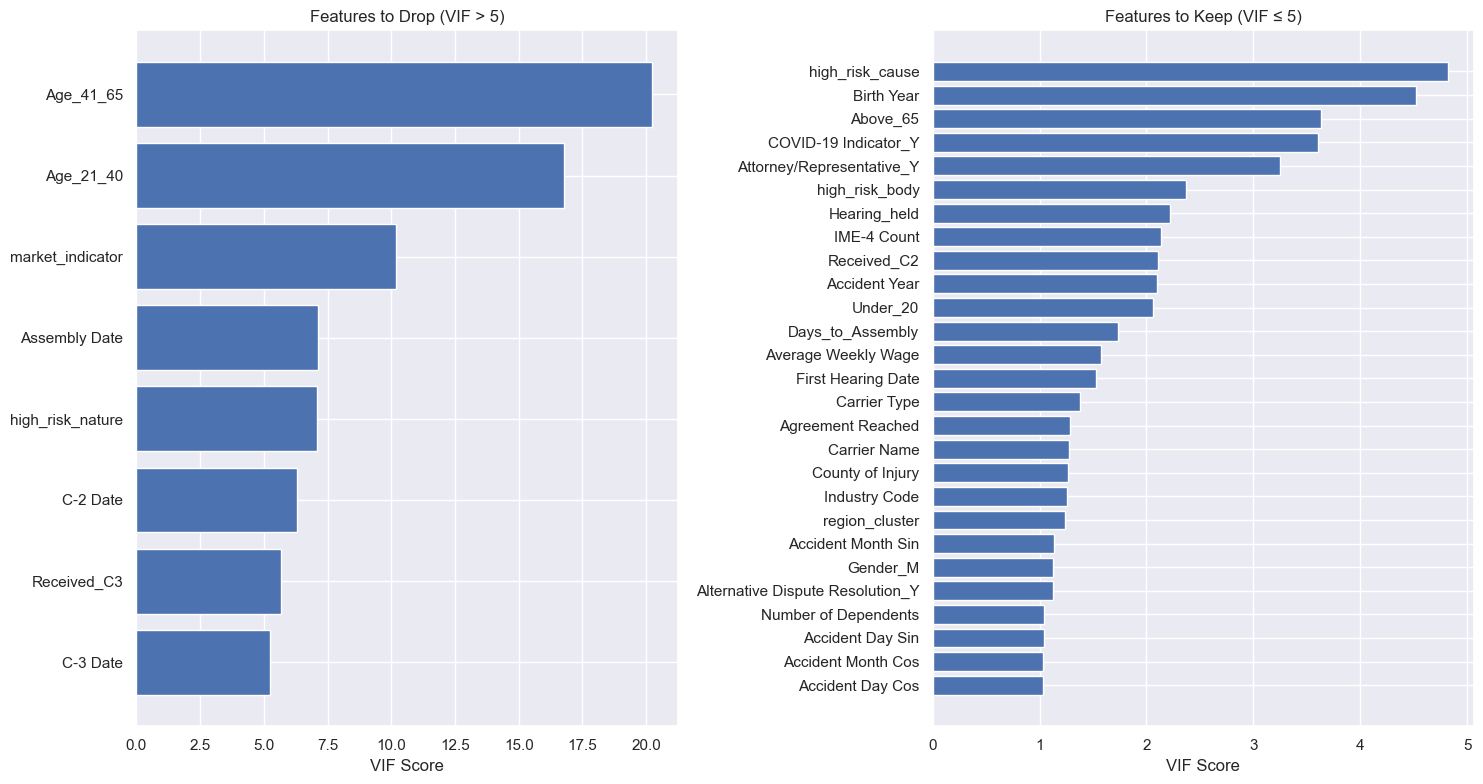

In [76]:
from sklearn.linear_model import LinearRegression
import numpy as np

def calculate_vif(X):
   vif_data = pd.DataFrame()
   vif_data["Feature"] = X_preproc_train.columns
   vif_data["VIF"] = [_calculate_vif(X, i) for i in range(X_preproc_train.shape[1])]
   return vif_data.sort_values('VIF', ascending=False)

def _calculate_vif(X, i):
   y = X.iloc[:, i]
   X_other = X_preproc_train.drop(X.columns[i], axis=1)
   model = LinearRegression()
   model.fit(X_other, y)
   r_squared = model.score(X_other, y)
   if r_squared == 1:
       return float('inf')
   return 1 / (1 - r_squared)

# Calculate VIF
vif_df = calculate_vif(X_preproc_train)

# Common thresholds
vif_thresholds = {
    'strict': 5,    # Remove VIF > 5
    'moderate': 10, # Remove VIF > 10
    'lenient': 20   # Remove VIF > 20
}

# Get features to drop
def get_vif_features(vif_df, threshold):
    return vif_df[vif_df['VIF'] > threshold]['Feature'].tolist()

# Remove infinite VIFs first
features_to_drop = vif_df[vif_df['VIF'].isin([float('inf')])]['Feature'].tolist()

# Print features to drop at each threshold
for name, threshold in vif_thresholds.items():
    features = get_vif_features(vif_df[vif_df['VIF'] != float('inf')], threshold)
    print(f"\n{name.title()} threshold ({threshold}):")
    print(f"Features to drop: {len(features)}")
    print(f"Features: {features}")

# Get all features with finite VIF scores, sorted
vif_df_finite = vif_df[vif_df['VIF'] != float('inf')].sort_values('VIF', ascending=True)

# Features to drop (VIF > 5)
features_to_drop = get_vif_features(vif_df_finite, 5)

# Features to keep (VIF <= 5)
features_to_keep = vif_df_finite[vif_df_finite['VIF'] <= 5]['Feature'].tolist()

# Save both lists to CSV
pd.DataFrame({
   'features_to_drop': pd.Series(features_to_drop),
   'features_to_keep': pd.Series(features_to_keep)
}).to_csv('fs1.csv', index=False)

import matplotlib.pyplot as plt

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Plot features to drop
vif_drop = vif_df_finite[vif_df_finite['VIF'] > 5]
ax1.barh(vif_drop['Feature'], vif_drop['VIF'])
ax1.set_title('Features to Drop (VIF > 5)')
ax1.set_xlabel('VIF Score')

# Plot features to keep
vif_keep = vif_df_finite[vif_df_finite['VIF'] <= 5]
ax2.barh(vif_keep['Feature'], vif_keep['VIF'])
ax2.set_title('Features to Keep (VIF ≤ 5)')
ax2.set_xlabel('VIF Score')

plt.tight_layout()
plt.show()

<a class="anchor" id="11th-bullet">

## Wrapper Methods
    
</a>

<a class="anchor" id="12th-bullet">

### RFE
    
</a>

<a class="anchor" id="13th-bullet">

#### RFE XGBoosting

</a>

Using RFE, the objective is finding the optimal number of features to select

### RFE XGBoosting

In [70]:
#number of features
nof_list= np.arange(1, 42)
high_score=0

#Variable to store the optimum features
nof=0
train_f1score_list =[]
val_f1score_list = []

for n in range(len(nof_list)):

    #using XGBoost
    model = XGBClassifier(
            objective='multi:softprob',
            random_state=42,
            learning_rate=0.05046195857265063,
            max_depth=14,
            min_child_weight=4.295663382738008,
            subsample=0.5794673021390964,
            colsample_bytree=0.6752893520492427,
            n_estimators=716,
            reg_alpha=0.2207882375290882,
            reg_lambda=0.28791727579162424,
            gamma=1.5556906330098323,
)

    rfe = RFECV(estimator = model,min_features_to_select = nof_list[n], step=1, cv=5)
    X_train_rfe = rfe.fit_transform(X_preproc_train,y_preproc_train)
    X_val_rfe = rfe.transform(X_preproc_val)

    model.fit(X_train_rfe,y_preproc_train)

    # Predictions for F1 score
    y_preproc_train_pred = model.predict(X_train_rfe)
    y_preproc_val_pred = model.predict(X_val_rfe)

    #storing results on training data
    train_f1score = f1_score(y_preproc_train,y_preproc_train_pred, average='macro')
    train_f1score_list.append(train_f1score)

    #storing results on training data
    val_f1score = f1_score(y_preproc_val,y_preproc_val_pred, average='macro')
    val_f1score_list.append(val_f1score)

    #check best score
    if(val_f1score >= high_score):
        high_score = val_f1score
        nof = nof_list[n]
        features_to_select = pd.Series(rfe.support_, index = X_preproc_train.columns)


print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")


KeyboardInterrupt: 

In [64]:

nof_list = np.arange(1, 42)
high_score = 0
nof = 0
scores = {}

# Get feature importances from base model
model = XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        learning_rate=0.05046195857265063,
        max_depth=14,
        min_child_weight=4.295663382738008,
        subsample=0.5794673021390964,
        colsample_bytree=0.6752893520492427,
        n_estimators=716,
        reg_alpha=0.2207882375290882,
        reg_lambda=0.28791727579162424,
        gamma=1.5556906330098323,
    )

model.fit(X_preproc_train, y_preproc_train)
importances = pd.Series(model.feature_importances_, index=X_preproc_train.columns)
sorted_features = importances.sort_values(ascending=False)

# Try different numbers of top features
for n in nof_list:
    selected_features = sorted_features.head(n).index
    X_train_selected = X_preproc_train[selected_features]
    X_val_selected = X_preproc_val[selected_features]

    model.fit(X_train_selected, y_preproc_train)
    val_pred = model.predict(X_val_selected)
    score = f1_score(y_preproc_val, val_pred, average='macro')
    scores[n] = score

    if score > high_score:
        high_score = score
        nof = n

best_features = sorted_features.head(nof).index
print(f"Optimal features: {nof}")
print(f"Best score: {high_score:.4f}")
print(f"Selected features:\n{best_features}")

Optimal features: 16
Best score: 0.5018
Selected features:
Index(['Average Weekly Wage', 'Attorney/Representative_Y', 'IME-4 Count',
       'Agreement Reached', 'Received_C2', 'Received_C3', 'Hearing_held',
       'Days_to_Assembly', 'Age_41_65', 'First Hearing Date',
       'WCIO Part Of Body Code', 'C-3 Date', 'market_indicator',
       'WCIO Nature of Injury Code', 'wcio_pca1', 'C-2 Date'],
      dtype='object')


## Permutation Importance

In [69]:
# from sklearn.inspection import permutation_importance
# import numpy as np
# import matplotlib.pyplot as plt



# def compute_importance_scores(model, X, y, n_repeats=10):
#    result = permutation_importance(
#        model, X, y,
#        n_repeats=n_repeats,
#        random_state=42,
#        n_jobs=-1
#    )

#    importances = pd.DataFrame(
#        {'Feature': X_preproc_train.columns,
#         'Importance': result.importances_mean,
#         'Std': result.importances_std}
#    )
#    return importances.sort_values('Importance', ascending=False)

# # Calculate importance
# ig_scores = compute_importance_scores(model, X_preproc_train, y_preproc_train)

# # Plot
# plt.figure(figsize=(12, 8))
# plt.errorbar(
#    ig_scores['Importance'],
#    np.arange(len(ig_scores)),
#    xerr=ig_scores['Std'],
#    fmt='o'
# )
# plt.yticks(np.arange(len(ig_scores)), ig_scores['Feature'])
# plt.xlabel('Feature Importance')
# plt.title('Permutation Feature Importance')
# plt.tight_layout()
# plt.show()

# # Save results
# ig_scores.to_csv('ig_scores.csv', index=False)

<a class="anchor" id="13th-bullet">

## Embedded Methods
    
</a>

<a class="anchor" id="14th-bullet">

### Lasso Regression
    
</a>

In [51]:
reg = LassoCV(cv=10, random_state=42)

reg.fit(X_preproc_train, y_preproc_train)

coef = pd.Series(reg.coef_, index = X_preproc_train.columns)
coef.sort_values()

high_risk_body                     -0.106161
high_risk_nature                   -0.087463
Above_65                           -0.068158
Accident Year                      -0.067528
County of Injury                   -0.026670
market_indicator                   -0.021966
C-2 Date                           -0.021576
Hearing_held                       -0.021290
Industry Code                      -0.018056
Carrier Type                       -0.004701
Number of Dependents               -0.001869
Carrier Name                       -0.001692
high_risk_cause                    -0.000000
Alternative Dispute Resolution_Y    0.000000
COVID-19 Indicator_Y               -0.000000
wcio_pca2                           0.000000
Age_41_65                          -0.000000
Under_20                            0.000000
Assembly Date                      -0.000000
WCIO Nature of Injury Code          0.000000
C-3 Date                            0.000000
WCIO Cause of Injury Code           0.000000
Days_to_As

Lasso picked 29 variables and eliminated the other 11 variables
Features eliminated: 
Assembly Date                      -0.0
C-3 Date                            0.0
WCIO Cause of Injury Code           0.0
WCIO Nature of Injury Code          0.0
Days_to_Assembly                    0.0
Under_20                            0.0
Age_41_65                          -0.0
COVID-19 Indicator_Y               -0.0
Alternative Dispute Resolution_Y    0.0
wcio_pca2                           0.0
high_risk_cause                    -0.0
dtype: float64


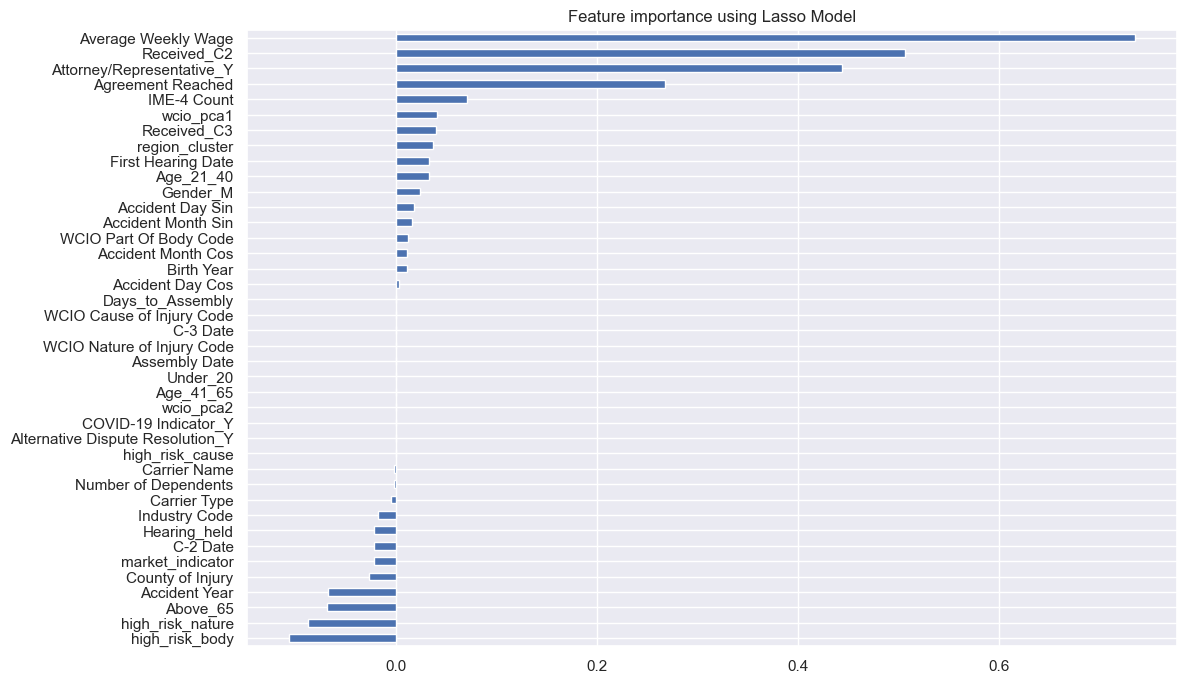

In [53]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
#print the features that were eliminated

features_eliminated = coef[coef == 0]
print(f"Features eliminated: \n{features_eliminated.sort_values()}")

plot_importance(coef,'Lasso')

<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>



| Predictor | Unvariate|  Spearman | Variance information factor (VIF)| (IG)Information Gain | XXX| Feature Imprtance XGB (SHAP)| RFE XGB | Lasso | Mutual Information Class. | What to do? |
| --- | --- | --- | --- |--- |--- |---|---|---|---| ---|
| Assembly Date | Keep | Drop? | --- |---|--- |---|---| Drop |Drop| ---|
| Average Weekly Wage | Keep | Keep | --- |---|--- |---|---| Keep | Keep | ---|
| Birth Year | Keep | Drop | --- |--- |---|---|---| Keep | Drop | ---|
| C-2 Date | Keep | Drop? | --- |--- |---|---|---| Keep | Drop | ---|
| C-3 Date | Keep | Keep | --- |--- |---|---|---| Drop | Keep | ---|
| Carrier Name | Keep | Keep | --- |--- |---|---|---| Keep | Keep | ---|
| Carrier Type | Keep | Keep | --- |--- |---|---|---| Keep | Drop | ---|
| County of Injury | Keep | Keep | --- |---|--- |---|---| Keep | Drop | ---|
| District Name | Keep | Keep | --- |--- |---|---|---| Keep | Drop | ---|
| First Hearing Date | Keep | Keep | --- |---|--- |---|---| Keep | Keep | ---|
| IME-4 Count | Keep | Keep | --- |--- |---|---|---| Keep | Keep | ---|
| Industry Code | Keep | Drop | --- |--- |---|---|---| Keep | Keep | ---|
| WCIO Cause of Injury Code | Keep | Keep | --- |---|--- |---|---| Drop | Keep | ---|
| WCIO Nature of Injury Code | Keep | Drop? | --- |---|--- |---|---| Drop | Keep | ---|
| WCIO Part Of Body Code | Keep | Keep | --- |--- |---|---|---| Keep | Keep | ---|
| Agreement Reached | Keep | --- | --- |--- |---|---|---|Keep| Keep | ---|
| Number of Dependents | Keep | Drop | --- |--- |---|---|---| Keep | Drop | ---|
| Accident Year | Keep | Keep | --- |--- |---|---|---|Keep| Drop | ---|
| Received_C2 | Keep | --- | --- |--- |---|---|---| Keep | Drop | ---|
| Received_C3 | Keep | --- | --- |--- |---|---|---| Keep | Keep | ---|
| Hearing_held | Keep | --- | --- |--- |---|---|---| Keep | Keep | ---|
| Attorney/Representative_Y | Keep | --- | --- |---|--- |---|---| Keep | Keep | ---|
| COVID-19 Indicator_Y | Keep | --- | --- |--- |---|---|---| Drop | Drop | ---|
| Alternative Dispute Resolution_Y | Keep | --- |---| --- |--- |---|---| Drop | Drop | ---|
| Gender_M | Keep | --- | --- |--- |---|---|---| Keep | Drop | ---|
| wcio_pca1 | Keep | Drop? | --- |--- |---|---|---| Keep | Keep | ---|
| wcio_pca2 | Keep | Keep | --- |--- |---|---|---| Drop | Keep | ---|
| region_cluster | Keep | Keep | --- |--- |---|---|---| Keep | Drop | ---|
| high_risk_nature | Keep | --- | --- |--- |---|---|---| Keep | Keep | ---|
| high_risk_body | Keep | --- | --- |--- |---|---|---| Keep | Drop | ---|
| high_risk_cause | Keep | --- | --- |--- |---|---|---| Drop |Drop| ---|
| Under_20 | Keep | --- | --- |--- |---|---|---| Drop | Drop | ---|
| Days_to_Assembly | Keep | --- | --- |--- |---|---|---| Drop | Keep | ---|
| Accident Month Cos | Keep | --- | --- |--- |---|---|---| Keep | Drop | ---|
| Age_21_40 | Keep | --- | --- |--- |---|---|---| Keep | Drop | ---|
| Above_65 | Keep | --- | --- |--- |---|---|---| Keep | Drop | ---|
| Accident Day Sin  | Keep | --- | --- |--- |---|---|---| Keep | Keep | ---|
| Age_41_65 | Keep | --- | --- |--- |---|---|---| Drop | Drop | ---|
| Accident Day Cos | Keep | --- | --- |---|--- |---|---| Keep | Drop | ---|
| Accident Month Sin | Keep | --- | --- |--- |---|---|---| Keep | Drop | ---|
| market_indicator | Keep | --- | --- |--- |---|---|---| Keep | Drop | ---|
<hr>





   
